In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv('./0530학습용_종목품명.csv')

In [3]:
num_account = {}
num_account_inverse = {}
for i, class_ in enumerate(df1['상대계정'].unique()):
    num_account[i] = class_
    num_account_inverse[class_] = i

In [4]:
len(num_account) # 44개의 classification class

44

In [5]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config
from torch.optim import Adam
import torch.nn.functional as F

In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [7]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, idx):
        text = str(self.df.iloc[idx, 4])
        label = self.df.iloc[idx, 5]
        return text, label
    
    def __len__(self):
        return len(self.df)

In [8]:
dataset_size = len(df1)
validation_split = .2
shuffle_dataset = True
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

In [9]:
if shuffle_dataset:    
    np.random.shuffle(indices)

In [10]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything()

In [11]:
dataset_train = CustomDataset(df1)
dataset_test = CustomDataset(df1)

train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=16, sampler = train_sampler, num_workers=1)
# val_loader = torch.utils.data.DataLoader(dataset_test, batch_size=8, sampler = val_sampler, num_workers=1)

# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,shuffle = True)
# validation_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,shuffle = False, num_workers=1)

In [12]:
torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda")
model_config = GPT2Config.from_pretrained('gpt2', num_labels=44)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config = model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

In [14]:
save_path = "./gpt2_classcode_44_230102_5e5_e4.pth"

In [15]:
from tqdm import tqdm

In [16]:
optimizer = Adam(model.parameters(), lr=5e-5) # 1e-6

itr = 1
p_itr = 100
epochs = 4
total_loss = 0
total_len = 0
total_correct = 0
acc_list = []
loss_list = []

model.train()

for epoch in tqdm(range(epochs)):
    
    for text, label in train_loader:
        optimizer.zero_grad()
        # encoding and zero padding
        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
        
        sample = torch.tensor(padded_list)
        sample, label = sample.to(device), label.to(device)
        labels = torch.tensor(label)
        outputs = model(sample, labels=labels)
        loss, logits = outputs[:2]

        pred = torch.argmax(F.softmax(logits), dim=1)
        correct = pred.eq(labels)
        total_correct += correct.sum().item()
        total_len += len(labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if itr % p_itr == 0:
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))
            acc_list.append(total_correct/total_len)
            loss_list.append(total_loss/p_itr)
            total_loss = 0
            total_len = 0
            total_correct = 0
        
        itr+=1
    #model.eval()
    

  0%|                                                     | 0/4 [00:00<?, ?it/s]/home/r320/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/r320/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 1/4] Iteration 100 -> Train Loss: 2.9863, Accuracy: 0.216
[Epoch 1/4] Iteration 200 -> Train Loss: 2.4675, Accuracy: 0.346
[Epoch 1/4] Iteration 300 -> Train Loss: 1.8632, Accuracy: 0.535
[Epoch 1/4] Iteration 400 -> Train Loss: 1.4862, Accuracy: 0.634
[Epoch 1/4] Iteration 500 -> Train Loss: 1.2486, Accuracy: 0.689
[Epoch 1/4] Iteration 600 -> Train Loss: 1.1217, Accuracy: 0.705
[Epoch 1/4] Iteration 700 -> Train Loss: 0.9874, Accuracy: 0.753
[Epoch 1/4] Iteration 800 -> Train Loss: 0.8518, Accuracy: 0.785
[Epoch 1/4] Iteration 900 -> Train Loss: 0.7573, Accuracy: 0.802
[Epoch 1/4] Iteration 1000 -> Train Loss: 0.7710, Accuracy: 0.799
[Epoch 1/4] Iteration 1100 -> Train Loss: 0.7297, Accuracy: 0.816


 25%|███████████                                 | 1/4 [06:55<20:45, 415.10s/it]

[Epoch 2/4] Iteration 1200 -> Train Loss: 0.5623, Accuracy: 0.863
[Epoch 2/4] Iteration 1300 -> Train Loss: 0.5057, Accuracy: 0.863
[Epoch 2/4] Iteration 1400 -> Train Loss: 0.4919, Accuracy: 0.876
[Epoch 2/4] Iteration 1500 -> Train Loss: 0.4628, Accuracy: 0.868
[Epoch 2/4] Iteration 1600 -> Train Loss: 0.4795, Accuracy: 0.873
[Epoch 2/4] Iteration 1700 -> Train Loss: 0.4460, Accuracy: 0.876
[Epoch 2/4] Iteration 1800 -> Train Loss: 0.4554, Accuracy: 0.873
[Epoch 2/4] Iteration 1900 -> Train Loss: 0.4046, Accuracy: 0.889
[Epoch 2/4] Iteration 2000 -> Train Loss: 0.4509, Accuracy: 0.873
[Epoch 2/4] Iteration 2100 -> Train Loss: 0.4485, Accuracy: 0.885
[Epoch 2/4] Iteration 2200 -> Train Loss: 0.4250, Accuracy: 0.883
[Epoch 2/4] Iteration 2300 -> Train Loss: 0.4214, Accuracy: 0.889


 50%|██████████████████████                      | 2/4 [13:51<13:51, 415.95s/it]

[Epoch 3/4] Iteration 2400 -> Train Loss: 0.3587, Accuracy: 0.904
[Epoch 3/4] Iteration 2500 -> Train Loss: 0.2988, Accuracy: 0.915
[Epoch 3/4] Iteration 2600 -> Train Loss: 0.2925, Accuracy: 0.917
[Epoch 3/4] Iteration 2700 -> Train Loss: 0.3410, Accuracy: 0.902
[Epoch 3/4] Iteration 2800 -> Train Loss: 0.3069, Accuracy: 0.914
[Epoch 3/4] Iteration 2900 -> Train Loss: 0.2902, Accuracy: 0.920
[Epoch 3/4] Iteration 3000 -> Train Loss: 0.2773, Accuracy: 0.917
[Epoch 3/4] Iteration 3100 -> Train Loss: 0.3268, Accuracy: 0.916
[Epoch 3/4] Iteration 3200 -> Train Loss: 0.2798, Accuracy: 0.921
[Epoch 3/4] Iteration 3300 -> Train Loss: 0.2979, Accuracy: 0.915
[Epoch 3/4] Iteration 3400 -> Train Loss: 0.2868, Accuracy: 0.916
[Epoch 3/4] Iteration 3500 -> Train Loss: 0.2405, Accuracy: 0.938


 75%|█████████████████████████████████           | 3/4 [20:48<06:56, 416.16s/it]

[Epoch 4/4] Iteration 3600 -> Train Loss: 0.2806, Accuracy: 0.922
[Epoch 4/4] Iteration 3700 -> Train Loss: 0.2205, Accuracy: 0.934
[Epoch 4/4] Iteration 3800 -> Train Loss: 0.2438, Accuracy: 0.929
[Epoch 4/4] Iteration 3900 -> Train Loss: 0.2345, Accuracy: 0.932
[Epoch 4/4] Iteration 4000 -> Train Loss: 0.2109, Accuracy: 0.934
[Epoch 4/4] Iteration 4100 -> Train Loss: 0.1904, Accuracy: 0.939
[Epoch 4/4] Iteration 4200 -> Train Loss: 0.2181, Accuracy: 0.939
[Epoch 4/4] Iteration 4300 -> Train Loss: 0.2308, Accuracy: 0.934
[Epoch 4/4] Iteration 4400 -> Train Loss: 0.2468, Accuracy: 0.931
[Epoch 4/4] Iteration 4500 -> Train Loss: 0.2279, Accuracy: 0.935
[Epoch 4/4] Iteration 4600 -> Train Loss: 0.2190, Accuracy: 0.927
[Epoch 4/4] Iteration 4700 -> Train Loss: 0.2591, Accuracy: 0.921


100%|████████████████████████████████████████████| 4/4 [27:43<00:00, 415.96s/it]


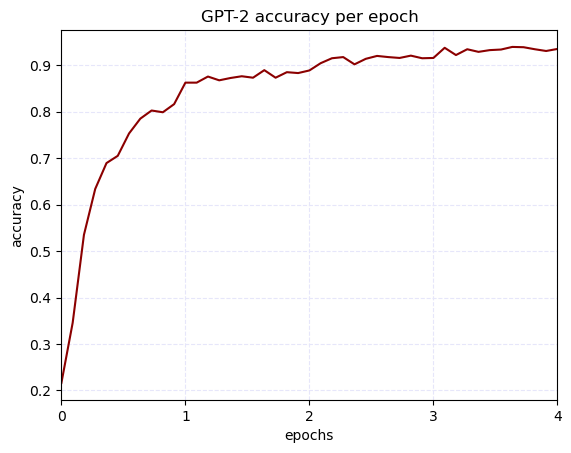

In [17]:
from matplotlib import pyplot as plt

fig = plt.figure()

x = np.arange(len(acc_list))/11

plt.plot(x, acc_list, label="Accuracy", color='darkred')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim([0, 4])
plt.xticks([0, 1, 2, 3, 4])
plt.title('GPT-2 accuracy per epoch')
plt.grid(linestyle='--', color='lavender')
# plt.show()
plt.savefig("gpt2_accuracy")

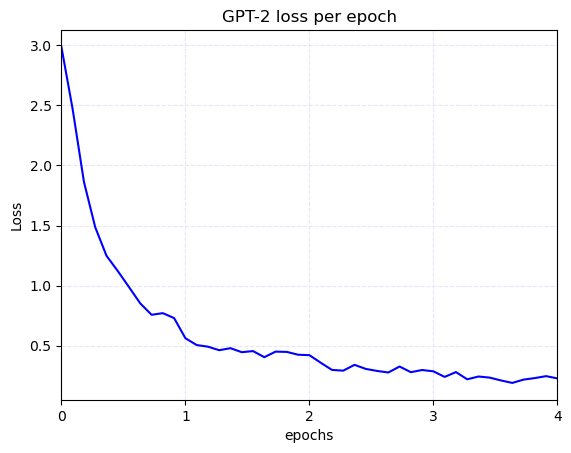

In [18]:
fig = plt.figure()

x = np.arange(len(loss_list))/11

plt.plot(x, loss_list, label="Loss", color='blue')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.xlim([0, 4])
plt.xticks([0, 1, 2, 3, 4])
plt.title('GPT-2 loss per epoch')
plt.grid(linestyle='--', color='lavender')
# plt.show()
plt.savefig("gpt2_loss")

torch.save(model.state_dict(), save_path)

In [15]:
model.load_state_dict(torch.load('./gpt2_classcode_44_230102_5e5_e4.pth'))

<All keys matched successfully>

In [16]:
model.eval()

# eval_dataset = CustomDataset(test_df)
# eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False, num_workers=2)
y = []
y_pred = []

total_loss = 0
total_len = 0
total_correct = 0

for text, label in val_loader:
    encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
    padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
    sample = torch.tensor(padded_list)
    sample, label = sample.to(device), label.to(device)
    labels = torch.tensor(label)
    outputs = model(sample, labels=labels)
    _, logits = outputs[:2]

    pred = torch.argmax(F.softmax(logits), dim=1)
    y_pred.append(pred)
    y.append(labels)
    correct = pred.eq(labels)
    total_correct += correct.sum().item()
    total_len += len(labels)

print('Test accuracy: ', total_correct / total_len)

/home/r320/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/home/r320/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy:  0.9400382734424835


In [27]:
print(y)

[tensor([ 8, 18,  8, 18,  1, 33, 18,  1], device='cuda:0'), tensor([ 3, 19,  6, 19,  4,  6, 18, 18], device='cuda:0'), tensor([ 1,  6, 11,  2,  3, 18, 24, 18], device='cuda:0'), tensor([18,  4,  3,  9,  8, 19, 24, 19], device='cuda:0'), tensor([39, 11,  4,  3,  3,  7, 18,  9], device='cuda:0'), tensor([ 3, 18,  1,  3, 18,  2,  3, 18], device='cuda:0'), tensor([22, 28, 40, 43,  4, 19,  3,  4], device='cuda:0'), tensor([ 3, 18, 19,  7, 39, 13, 28,  6], device='cuda:0'), tensor([19, 18,  3, 19,  0,  3, 19,  3], device='cuda:0'), tensor([ 9,  3,  3,  3,  1,  1,  3, 19], device='cuda:0'), tensor([18, 18, 18, 19, 11,  3,  3, 10], device='cuda:0'), tensor([ 8, 19, 19,  3, 18, 10, 18, 13], device='cuda:0'), tensor([ 4,  4,  6, 18,  6,  3,  4, 18], device='cuda:0'), tensor([ 3,  1, 19,  3, 18,  6, 18, 18], device='cuda:0'), tensor([18,  4, 33,  6, 13,  1, 33, 11], device='cuda:0'), tensor([ 3, 33, 11, 22,  4,  3, 33,  6], device='cuda:0'), tensor([ 2,  3,  4, 18,  6, 18, 32,  1], device='cuda:0

In [30]:
y_list_ = []
pred_list_ = []
for y_ in y:
    y_list_.append(y_.tolist())
    # pred_list_.append(pred_.tolist())
for pred_ in y_pred:
    pred_list_.append(pred_.tolist())

In [33]:
y_list = sum(y_list_, [])
pred_list = sum(pred_list_, [])

In [38]:
from sklearn.metrics import f1_score

In [39]:
f1score = f1_score(y_true=y_list, y_pred=pred_list, average='weighted')

In [40]:
print(f1score)

0.9384124313364035
